# Project 3. Tripadvisor-rating

### Goal: predict TripAdvisor Rating
###### Выполнил: Stor Dmitriy

In [1]:
from sklearn import metrics  # инструменты для оценки точности модели
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Загружаем специальный инструмент для разбивки:

# Импортируем необходимые библиотеки:

### Preprocessing

In [2]:
def split_data(el, sep=','):
    """split data in column by separator & get Series"""
    return pd.Series(el.str.cat(sep=sep).split(sep))


def reviews_date(str, count):
    """ get date from reviews """
    date = re.findall(r'\d\d?/\d\d?/\d+', str)
    if len(date) == 0:
        return np.nan
    if count == 1:
        return pd.to_datetime(date[0])
    elif len(date) == 2:
        return pd.to_datetime(date[1])
    else:
        return np.nan

# DATA

In [3]:
data = pd.read_csv('main_task.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


Подробнее по признакам:
* City: Город 
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com' 
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [5]:
data.sample(5)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
15153,id_4289,Barcelona,NaN,4290.0,5.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187497-d12975535-Reviews-R...,d12975535
20672,id_480,Paris,"['French', 'Bar', 'Pub', 'European', 'Vegetari...",481.0,4.5,$$ - $$$,187.0,"[['Nice staff good food reasonable prices', 'O...",/Restaurant_Review-g187147-d12058517-Reviews-L...,d12058517
17269,id_5826,London,"['French', 'Cafe', 'British', 'Delicatessen']",5835.0,4.5,$$ - $$$,30.0,"[['The place for cooked breakfast', 'Fabulous ...",/Restaurant_Review-g186338-d5984281-Reviews-Le...,d5984281
4716,id_6051,Madrid,['Russian'],6054.0,4.0,$$$$,15.0,"[[], []]",/Restaurant_Review-g187514-d1992937-Reviews-19...,d1992937
6381,id_5221,Barcelona,"['Japanese', 'Seafood', 'Sushi', 'Asian']",5222.0,3.5,$$ - $$$,78.0,"[['Good quality/price rate', 'Never Again.'], ...",/Restaurant_Review-g187497-d2067255-Reviews-Ta...,d2067255


In [6]:
data.shape

(40000, 10)

# 1. Cleaning data

In [7]:
# check NAN values
data.apply(lambda x: x.isnull().sum())

Restaurant_id            0
City                     0
Cuisine Style         9283
Ranking                  0
Rating                   0
Price Range          13886
Number of Reviews     2543
Reviews                  0
URL_TA                   0
ID_TA                    0
dtype: int64

In [8]:
# 'Restaurant_id' is very similar to 'Ranking'
# remove prefix 'id_' in the columns Restaurant_id
data.loc[:, 'Restaurant_id'] = data['Restaurant_id'].str.replace(
    'id_', '').astype(float)

In [9]:
# Cuisine Style
# remove parentheses and apostrophes
data.loc[:, 'Cuisine Style'] = data['Cuisine Style'].str[1:-
                                                         1].str.replace(', ', ',').str.replace('\s', '_')

# create a column 'Cuisine_Style_isNAN'
data['Cuisine_Style_isNAN'] = pd.isna(data['Cuisine Style']).astype('uint8')

# fill with mode
modes = data.groupby('City')['Cuisine Style'].apply(
    lambda x: split_data(x).mode()).reset_index(level=1, drop=True)
for c in data['City'].unique():
    value = modes[modes.index == c].iloc[0]
    data.loc[(data["City"] == c) & (
        data['Cuisine Style'].isnull()), 'Cuisine Style'] = value

In [10]:
# Price Range
# create a column 'Price_Range_isNAN'
data['Price_Range_isNAN'] = pd.isna(data['Price Range']).astype('uint8')
# get mode
mode = data['Price Range'].mode().iloc[0]
# fill with mode
data['Price Range'].fillna(mode, inplace=True)

In [11]:
# Reviews
# remove parentheses and others
data.loc[:, 'Reviews'] = data.loc[:, 'Reviews'].str.replace("[", '').str.replace(
    "]", '').str.replace("'", "").str.replace(", ", " ").str.strip()

# replace empty '' values with NAN
data.loc[:, 'Reviews'] = data.loc[:, 'Reviews'].apply(
    lambda x: np.nan if x == '' else x)

# create a column 'Reviews_isNAN'
data['Reviews_isNAN'] = pd.isna(data['Reviews']).astype('uint8')

# fill NAN values
data.Reviews.fillna('no review', inplace=True)

In [12]:
# Number of Reviews
# create a column Number_of_Reviews_isNAN
data['Number_of_Reviews_isNAN'] = pd.isna(
    data['Number of Reviews']).astype('uint8')

# fill NAN with median in 'Number of Reviews' by 'City'
Num_Rev_medians = data.groupby("City")['Number of Reviews'].transform('median')
data['Number of Reviews'].fillna(Num_Rev_medians, inplace=True)

In [13]:
# check NAN values
data.isnull().sum().any()

False

In [14]:
data.shape

(40000, 14)

### 2. Обработка признаков

In [15]:
# посмотрим какие признаки могут быть категориальными.
data.nunique(dropna=False)

Restaurant_id              11909
City                          31
Cuisine Style               9007
Ranking                    11936
Rating                         9
Price Range                    3
Number of Reviews           1461
Reviews                    33516
URL_TA                     39980
ID_TA                      39980
Cuisine_Style_isNAN            2
Price_Range_isNAN              2
Reviews_isNAN                  2
Number_of_Reviews_isNAN        2
dtype: int64

In [16]:
# City
# save an original column 'City'
data.loc[:, 'City_orig'] = data.City

# One-Hot Encoding
data = pd.get_dummies(data, columns=['City', ], dummy_na=True)
data.rename(columns={"City_orig": "City"}, inplace=True)

In [17]:
# Cuisine Style - step 1
# Create a new columns with number of Cuisine Style
data.loc[:, 'Number of cuisine'] = data['Cuisine Style'].str.count(',')+1

In [18]:
# Cuisine Style - step 2
# get list of Cuisine stylies
cuisines = set(data['Cuisine Style'].str.cat(sep=",").split(","))

# create new columns for every Cuisine Style and fill
for c in cuisines:
    col_name = 'Cuisine_' + c.replace("'", '')
    data.loc[data['Cuisine Style'].str.contains(c), col_name] = 1
    data.loc[:, col_name].fillna(0, inplace=True)

#### Рассмотрим признак "Price Range".

In [19]:
data['Price Range'].value_counts()

$$ - $$$    32298
$            6279
$$$$         1423
Name: Price Range, dtype: int64

По описанию 'Price Range' это - Цены в ресторане.  
Их можно поставить по возрастанию (значит это не категориальный признак). А это значит, что их можно заменить последовательными числами, например 1,2,3

In [20]:
# Price Range
price_dict = {
    '$': 0,
    '$$ - $$$': 1,
    '$$$$': 2
}
data['Price Range'] = data['Price Range'].replace(to_replace=price_dict)

In [21]:
# Reviews - step 1

# Create a new columns with dates from Reviews
data.loc[:, 'Reviews_date1'] = data['Reviews'].apply(
    lambda x: reviews_date(x, 1))
data.loc[:, 'Reviews_date2'] = data['Reviews'].apply(
    lambda x: reviews_date(x, 2))

# get mode for dates by City
Rev_date1_modes = data.groupby("City")['Reviews_date1'].apply(
    lambda x: x.mode()).reset_index(level=1, drop=True)
Rev_date2_modes = data.groupby("City")['Reviews_date1'].apply(
    lambda x: x.mode()).reset_index(level=1, drop=True)

# fill NAN values 'Reviews_date' with mode by 'City'
for c in data['City'].unique():
    value1 = Rev_date1_modes[Rev_date1_modes.index == c].iloc[0]
    value2 = Rev_date2_modes[Rev_date2_modes.index == c].iloc[0]
    data.loc[(data['City'] == c) & (data['Reviews_date1'].isnull()),
             'Reviews_date1'] = value1
    data.loc[(data['City'] == c) & (data['Reviews_date2'].isnull()),
             'Reviews_date2'] = value2

In [22]:
# Reviews - step 2

# create columns with year, month, day
data.loc[:, 'Reviews1_year'] = data['Reviews_date1'].dt.year
data.loc[:, 'Reviews1_month'] = data['Reviews_date1'].dt.month
data.loc[:, 'Reviews1_day'] = data['Reviews_date1'].dt.day
data.loc[:, 'Reviews2_year'] = data['Reviews_date2'].dt.year
data.loc[:, 'Reviews2_month'] = data['Reviews_date2'].dt.month
data.loc[:, 'Reviews2_day'] = data['Reviews_date2'].dt.day

In [23]:
data.shape

(40000, 180)

# EDA 
[Exploratory Data Analysis](https://ru.wikipedia.org/wiki/Разведочный_анализ_данных) - Анализ данных
На этом этапе мы строим графики, ищем закономерности, аномалии, выбросы или связи между признаками.
В общем цель этого этапа понять, что эти данные могут нам дать и как признаки могут быть взаимосвязаны между собой.
Понимание изначальных признаков позволит сгенерировать новые, более сильные и, тем самым, сделать модель лучше.

### Посмотрим распределение признака

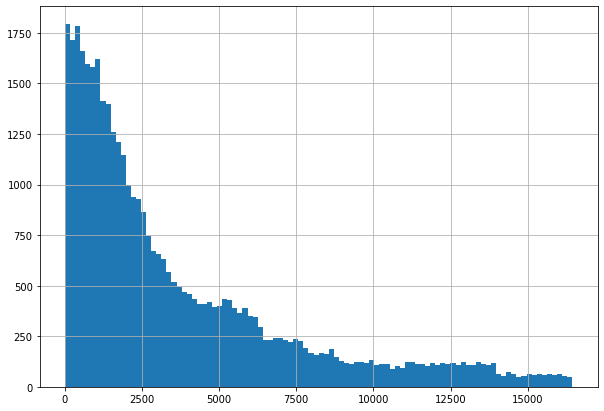

In [24]:
plt.rcParams['figure.figsize'] = (10, 7)
data['Ranking'].hist(bins=100)

У нас много ресторанов, которые не дотягивают и до 2500 места в своем городе, а что там по городам?

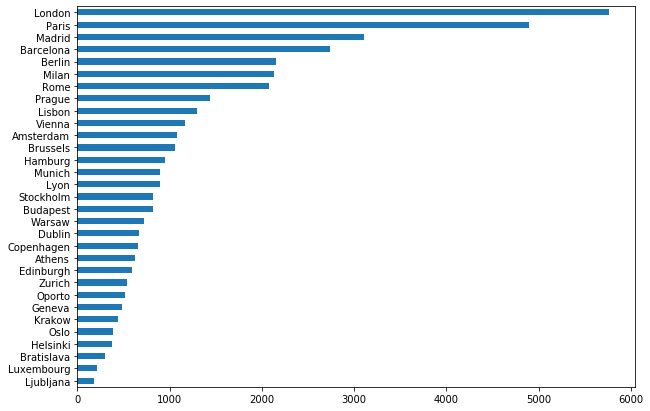

In [25]:
data['City'].value_counts(ascending=True).plot(kind='barh')

А кто-то говорил, что французы любят поесть=) Посмотрим, как изменится распределение в большом городе:

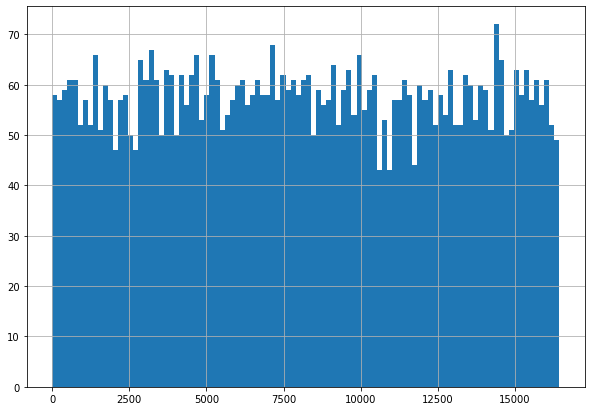

In [26]:
data['Ranking'][data['City'] == 'London'].hist(bins=100)

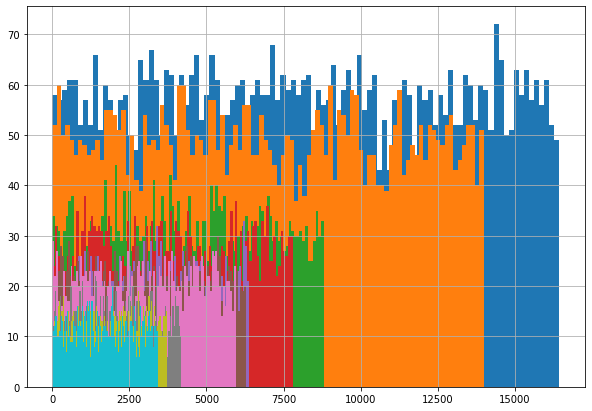

In [27]:
# посмотрим на топ 10 городов
for x in (data['City'].value_counts())[0:10].index:
    data['Ranking'][data['City'] == x].hist(bins=100)
plt.show()

Получается, что Ranking имеет нормальное распределение, просто в больших городах больше ресторанов, из-за этого имеем смещение.


### Посмотрим распределение целевой переменной

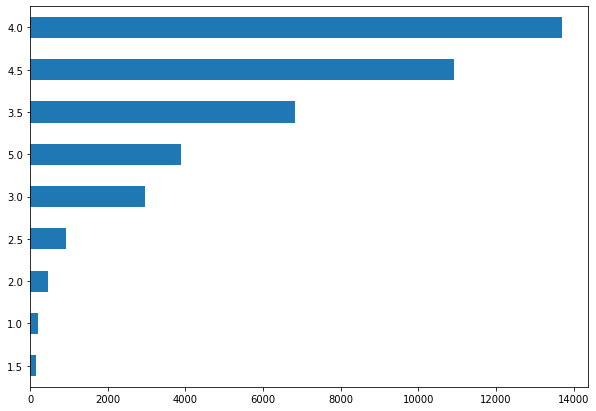

In [28]:
data['Rating'].value_counts(ascending=True).plot(kind='barh')

### Посмотрим распределение целевой переменной относительно признака

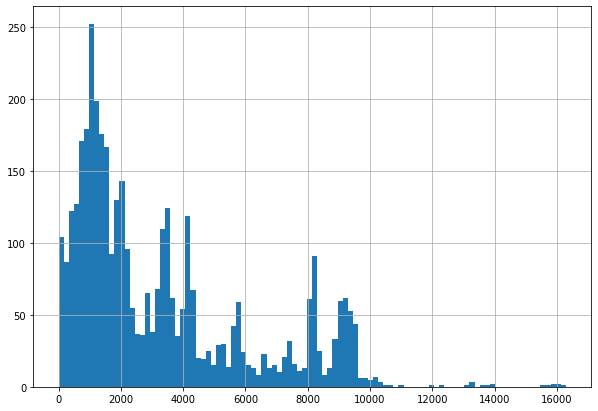

In [29]:
data['Ranking'][data['Rating'] == 5].hist(bins=100)

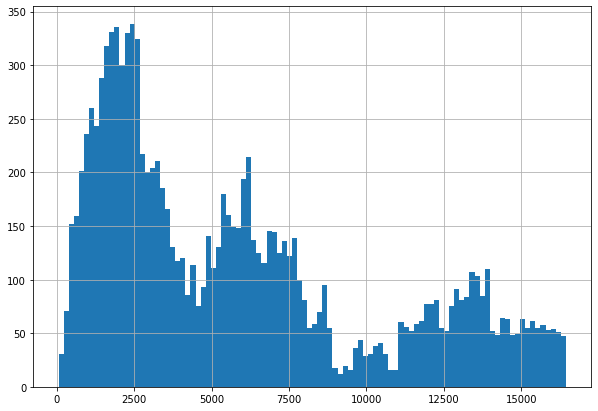

In [30]:
data['Ranking'][data['Rating'] < 4].hist(bins=100)

### [корреляция признаков](https://ru.wikipedia.org/wiki/Корреляция)
На этом графике можно заметить, как признаки связаны между собой и с целевой переменной.

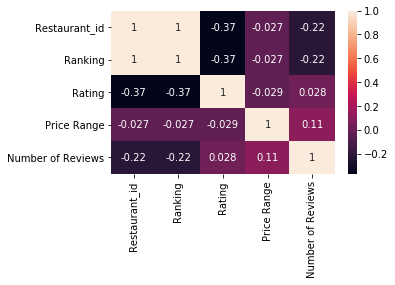

In [31]:
# heatmap
num_cols = ['Restaurant_id', 'Ranking',
            'Rating', 'Price Range', 'Number of Reviews']
plt.figure(figsize=(5, 3))
sns.heatmap(data[num_cols].corr(), annot=True)
plt.show()

In [32]:
# Strong correlation between 'Restaurant_id' & 'Ranking
data.corr()['Restaurant_id']['Ranking']

0.9999995570800042

#### Интересных фактоы

Сколько пицерий в Мадриде и Лондоне

In [33]:
for city in ['London', 'Madrid']:
    name = 'City_' + city
    n = data[data[name] == 1]['Cuisine Style'].apply(
        lambda x: 'Pizza' in str(x)).sum()
    print(city, n)

London 393
Madrid 103


Сколько типов кухонь представлено в наборе данных?

In [34]:
split_data(data['Cuisine Style']).nunique()

125

Какая кухня представлена в наибольшем количестве ресторанов?

In [35]:
split_data(data['Cuisine Style']).value_counts().head(1)

'Vegetarian_Friendly'    13868
dtype: int64

Какое среднее количество кухонь предлагается в одном ресторане?

In [36]:
round(data['Number of cuisine'].mean(), 1)

2.6

В каком городе кухня ресторанов более разнообразна?

In [37]:
max_cuisine = data['Number of cuisine'].max()
data[data['Number of cuisine'] == max_cuisine]['City'].iloc[0]

'Amsterdam'

Когда был оставлен самый свежий отзыв?

In [38]:
data.loc[:, ['Reviews_date1', 'Reviews_date1']].max().max()

Timestamp('2018-02-26 00:00:00')

Какое максимальное количество дней отделяет даты публикации отзывов?

In [39]:
max(data.loc[:, 'Reviews_date1'] - data.loc[:, 'Reviews_date2'])
#data[data.loc[:, 'Reviews_days_between'] == max_days][['Reviews_date2', 'Reviews_days_between']]

Timedelta('3207 days 00:00:00')

Drop columns

In [40]:
data.drop(['Restaurant_id', 'Reviews_date1',
           'Reviews_date2'], axis=1, inplace=True)
data.drop(data.select_dtypes('O'), axis=1, inplace=True)

In [41]:
data.shape

(40000, 172)

# Data Preprocessing
Теперь, для удобства и воспроизводимости кода, завернем всю обработку в одну большую функцию.

In [42]:
# аново подгружаем данные
data = pd.read_csv('main_task.csv')

In [43]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''

    ####### 1. Предобработка #######
    df_output = df_input.copy()
    # убираем не нужные для модели признаки
    df_output.drop(['Restaurant_id', 'URL_TA', 'ID_TA'], axis=1, inplace=True)
    # remove and symbols
    df_output.loc[:, 'Cuisine Style'] = df_output['Cuisine Style'].str[1:-
                                                                       1].str.replace(', ', ',').str.replace('\s', '_')
    df_output.loc[:, 'Reviews'] = df_output.loc[:, 'Reviews'].str.replace(
        "[", '').str.replace("]", '').str.replace("'", "").str.replace(", ", " ").str.strip()
    # replace empty '' values with NAN
    df_output.loc[:, 'Reviews'] = df_output.loc[:, 'Reviews'].apply(
        lambda x: np.nan if x == '' else x)

    # ######## 2. NAN #######
    # - Cuisine Style
    df_output['Cuisine_Style_isNAN'] = pd.isna(
        df_output['Cuisine Style']).astype('uint8')
    modes = df_output.groupby('City')['Cuisine Style'].apply(
        lambda x: split_data(x).mode()).reset_index(level=1, drop=True)
    for c in df_output['City'].unique():
        value = modes[modes.index == c].iloc[0]
        df_output.loc[(df_output["City"] == c) & (
            df_output['Cuisine Style'].isnull()), 'Cuisine Style'] = value
    # - Price Range
    df_output['Price_Range_isNAN'] = pd.isna(
        df_output['Price Range']).astype('uint8')
    price_mode = df_output['Price Range'].mode().iloc[0]
    df_output['Price Range'].fillna(price_mode, inplace=True)
    # - Reviews
    df_output['Reviews_isNAN'] = pd.isna(df_output['Reviews']).astype('uint8')
    df_output.Reviews.fillna('no review', inplace=True)
    # - Number of Reviews
    df_output['Number_of_Reviews_isNAN'] = pd.isna(
        df_output['Number of Reviews']).astype('uint8')
    Num_Rev_medians = df_output.groupby(
        "City")['Number of Reviews'].transform('median')
    df_output['Number of Reviews'].fillna(Num_Rev_medians, inplace=True)

    # ####### 3. Encoding #######
    # - City
    # save an original column 'City'
    df_output.loc[:, 'City_orig'] = df_output.City
    # для One-Hot Encoding
    df_output = pd.get_dummies(df_output, columns=['City', ], dummy_na=True)
    df_output.rename(columns={"City_orig": "City"}, inplace=True)
    # - Price Range
    price_dict = {
        '$': 0,
        '$$ - $$$': 1,
        '$$$$': 2
    }
    df_output['Price Range'] = df_output['Price Range'].replace(
        to_replace=price_dict)
    # ### end Encoding

    # ### 4. Feature Engineering
    # - Cuisine Style
    # Create a new columns with number of Cuisine Style
    df_output.loc[:, 'Number of cuisine'] = df_output['Cuisine Style'].str.count(
        ',')+1
    # get list of Cuisine stylies
    cuisines = set(df_output['Cuisine Style'].str.cat(sep=",").split(","))
    # create new columns for every Cuisine Style and fill
    for c in cuisines:
        col_name = 'Cuisine_' + c.replace("'", '')
        df_output.loc[df_output['Cuisine Style'].str.contains(c), col_name] = 1
        df_output.loc[:, col_name].fillna(0, inplace=True)
     # - Reviews
    # Create a new columns with dates from Reviews
    df_output.loc[:, 'Reviews_date1'] = df_output['Reviews'].apply(
        lambda x: reviews_date(x, 1))
    df_output.loc[:, 'Reviews_date2'] = df_output['Reviews'].apply(
        lambda x: reviews_date(x, 2))
    Rev_date1_modes = df_output.groupby("City")['Reviews_date1'].apply(
        lambda x: x.mode()).reset_index(level=1, drop=True)
    Rev_date2_modes = df_output.groupby("City")['Reviews_date1'].apply(
        lambda x: x.mode()).reset_index(level=1, drop=True)
    # fill NAN values 'Reviews_date' with mode by 'City'
    for c in df_output['City'].unique():
        value1 = Rev_date1_modes[Rev_date1_modes.index == c].iloc[0]
        value2 = Rev_date2_modes[Rev_date2_modes.index == c].iloc[0]
        df_output.loc[(df_output['City'] == c) & (
            df_output['Reviews_date1'].isnull()), 'Reviews_date1'] = value1
        df_output.loc[(df_output['City'] == c) & (
            df_output['Reviews_date2'].isnull()), 'Reviews_date2'] = value2
    # create columns with year, month, day
    df_output.loc[:, 'Reviews1_year'] = df_output['Reviews_date1'].dt.year
    df_output.loc[:, 'Reviews1_month'] = df_output['Reviews_date1'].dt.month
    df_output.loc[:, 'Reviews1_day'] = df_output['Reviews_date1'].dt.day
    df_output.loc[:, 'Reviews2_year'] = df_output['Reviews_date2'].dt.year
    df_output.loc[:, 'Reviews2_month'] = df_output['Reviews_date2'].dt.month
    df_output.loc[:, 'Reviews2_day'] = df_output['Reviews_date2'].dt.day

    # ####### 5. Clean #######
    # убираем признаки которые еще не успели обработать,
    object_columns = [
        s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis=1, inplace=True)
    df_output.drop(['Reviews_date1', 'Reviews_date2'], axis=1, inplace=True)

    return df_output

#### Запускаем и проверяем что получилось

In [44]:
df_preproc = preproc_data(data)
df_preproc.sample(5)

,Ranking,Rating,Price Range,Number of Reviews,Cuisine_Style_isNAN,Price_Range_isNAN,Reviews_isNAN,Number_of_Reviews_isNAN,City_Amsterdam,City_Athens,...,Cuisine_Central_Asian,Cuisine_Turkish,Cuisine_Mexican,Cuisine_Minority_Chinese,Reviews1_year,Reviews1_month,Reviews1_day,Reviews2_year,Reviews2_month,Reviews2_day
4658,1345.0,5.0,1,3.0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,2017,9,10,2017,7,8
17588,71.0,4.0,1,4937.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2018,1,9,2018,1,3
32454,2375.0,3.5,1,44.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2016,5,25,2016,5,9
34504,12745.0,3.0,1,3.0,1,1,0,0,0,0,...,0.0,0.0,0.0,0.0,2017,9,22,2018,1,7
14053,12002.0,4.0,1,10.0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,2016,2,8,2018,1,7


In [45]:
df_preproc.shape

(40000, 172)

### Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [46]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df_preproc.drop(['Rating'], axis=1)
y = df_preproc['Rating']

In [47]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Model

#### Создаём, обучаем и тестируем модель

In [48]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [49]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.2140125
